# Challenging Limitations: Using Deep Learning, Time Series Analysis, and Statistical Methods for Noise Reduction to Develop an Innovative Approach to Exoplanet Candidate Detection

## I. A Comparative Visualization of the Star Fields Visible to Earth-Based and Space-Based Telescopes

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('orange',
      dtype='<U6'), texture=None, triangles=array([[0, 1, 2],
       [0, 1, 3],
       [0, 2, 3],
       [1, 3, 2]], dtype=uint32), x=array([ 1., -1.,  0.,  0.]), y=array([ 0.,  0.,  1., -1.]), z=array([-0.70710678, -0.70710678,  0.70710678,  0.70710678]))], scatters=[Scatter(color=array('blue',
      dtype='<U4'), color_selected=array('white',
      dtype='<U5'), geo='sphere', size=array(2), size_selected=array(2.6), x=array([ 1., -1.,  0.,  0.]), y=array([ 0.,  0.,  1., -1.]), z=array([-0.70710678, -0.70710678,  0.70710678,  0.70710678]))], style={'box': {'visible': True}, 'background-color': 'white', 'axes': {'visible': True, 'ticklabel': {'color': 'black'}, 'label': {'color': 'black'}, 'color': 'black'}}, tf=None, width=400, xlim=[-2.0, 2.0], ylim=[-2.0, 2.0], zlim=[-2.0, 2.0]),))

In [1]:
import pandas as pd
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import math
import ipyvolume as ipv
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink
import ipyvolume.pylab as p3

class StarDF(object):
    def __init__(self, path, parse_placeholders, parse_prelim_nans):
        self.path = path
        self.parse_placeholders = parse_placeholders
        self.parse_prelim_nans = parse_prelim_nans
        
    def _gen_df(self):
        data = pd.read_csv(self.path)
        return data
       
    def _initialize(self):
        data = self._gen_df()
        if self.parse_placeholders is True:
            data = data.loc[data['dist'] < 100000]
            data = data.reset_index(drop=True)
        if self.parse_prelim_nans is False:
            data = data[1:]
            data = data.reset_index(drop=True)
        return data
    
    def get_full(self):
        data = self._initialize()
        return data
    
    def split(self):
        data = self._initialize()
        ra = data['ra']
        dec = data['dec']
        dist = data['dist']
        return ra, dec, dist
    
    def split_other(self, data):
        ra = data['ra']
        dec = data['dec']
        dist = data['dist']
        return ra, dec, dist
    
    def convert_to_degrees(self):
        df = self.initialize()
        ra = df['RA_STRING']
        dec = df['DEC_STRING']
        ra = ra.values
        dec = dec.values
        new_ra = np.empty(len(ra))
        new_dec = np.empty(len(dec))
        for i in range(0,len(ra)):
            coord = ra[i] + " " + dec[i]
            c = SkyCoord(coord, unit=(u.hourangle, u.deg))
            temp = c.to_string('decimal')
            temp_b = temp.split(' ')
            new_ra[i] = temp_b[0]
            new_dec[i] = temp_b[1]
        temp = {'ra': new_ra, 'dec': new_dec}
        exo_data = pd.DataFrame(temp, columns = ['ra', 'dec'])
        return exo_data
    
    def intersection(self, df1, df2, cols):
        intersect = pd.merge(df1, df2, on=cols, how='inner')
        intersect = intersect.reset_index(drop=True)
        return intersect
    
    def convert_to_cartesian(self, ra,dec,dist,n =1000):
        x = np.empty(n)
        y = np.empty(n)
        z = np.empty(n)
        for i in range(0,n):
            z[i] = dist[i] * np.sin(dec[i])
            phi = dist[i] * np.cos(dec[i])
            y[i] = phi * np.sin(ra[i])
            x[i] = phi * np.cos(ra[i])
        return x,y,z
    
    def integ_cartesian(self, ra,dec,dist):
        w = dist * np.sin(dec)
        phi = dist * np.cos(dec)
        v = phi * np.sin(ra)
        u = phi * np.cos(ra)
        return u,v,w
    
    def get_stats(self, array):
        return np.mean(array), np.std(array)
    


#parse for dubious parallax data as indicated by HYG database
fullHYG = StarDF('stardata_hyg_v2.csv', parse_placeholders=True, parse_prelim_nans = False)
fullHYG_df = fullHYG.get_full()
hyg_ra, hyg_dec, hyg_dist = fullHYG.split()

exo = StarDF('exo_data.csv', parse_placeholders = False, parse_prelim_nans = True)
exo_df = exo.get_full()

hyg_temp = fullHYG_df.dropna(thresh=7)
exo_temp = exo_df.dropna(thresh=3)
cols = ['HD', 'HIPP']
exo_stars = exo.intersection(hyg_temp, exo_temp, cols)
exo_ra, exo_dec, exo_dist = exo.split_other(exo_stars)

hyg_x,hyg_y,hyg_z = fullHYG.convert_to_cartesian(hyg_ra,hyg_dec,hyg_dist, n = len(hyg_ra))
exo_x, exo_y, exo_z = exo.convert_to_cartesian(exo_ra, exo_dec, exo_dist, n = len(exo_ra))
    
#initialize kepler vars
kep_x, kep_y, kep_z = np.empty(1), np.empty(1), np.empty(1)
kep_x[0] = 0
kep_y[0] = 0
kep_z[0] = 0
kep_u, kep_v, kep_w = np.empty(1), np.empty(1), np.empty(1)
#following params are center of kepler star field and depth of view of kepler telescope
kep_ra = 290.6667
kep_dec = 44.5
kep_dist = 919.8042
u,v,w = exo.integ_cartesian(kep_ra, kep_dec, kep_dist)
kep_u[0] = u
kep_v[0] = v
kep_w[0] = w


# 4 vertices for the tetrahedron
x_a, y_a, z_a = exo.integ_cartesian(kep_ra, kep_dec+7.5, 919.8042/np.cos(7.5))
x_b, y_b,z_b = exo.integ_cartesian(kep_ra+7.5, kep_dec, 919.8042/np.cos(7.5))
x_c, y_c, z_c = exo.integ_cartesian(kep_ra-7.5, kep_dec, 919.8042/np.cos(7.5))
x = np.array([0., x_a , x_b,  x_c])
y = np.array([0, y_a,  y_b, y_c])
z = np.array([0, z_a, z_b,  z_c])
# and 4 surfaces (triangles), where the numbers refer to the vertex index
triangles = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1,3,2)]
# we draw the tetrahedron


ipv.figure()
selected = (hyg_x[0], hyg_y[0], hyg_z[0])
scatter_a = ipv.scatter(hyg_x,hyg_y,hyg_z,size=0.15, size_selected = 0.6, marker="sphere", selected = selected)
exo_scatter = ipv.scatter(exo_x, exo_y, exo_z, size = 0.6, marker = 'sphere', color= '#00c8ff')

linex =np.array([0,kep_u])
liney = np.array([0, kep_v])
linez = np.array([0,kep_w])
p3.plot(linex, liney ,linez, color='blue')
#p3.plot_trisurf(linex, liney, linez, triangles=triangles, color='orange')

size = FloatSlider(min=0.1, max=1, step=0.05)
color = ColorPicker()
color_selected = ColorPicker()
exo_color = ColorPicker()
kep_color = ColorPicker()
kep_size = FloatSlider(min=0, max = 10, step = 0.1)
jslink((scatter_a, 'size'), (size, 'value'))
jslink((scatter_a, 'color'), (color, 'value'))
jslink((scatter_a, 'color_selected'), (color_selected, 'value'))
jslink((exo_scatter, 'color'), (exo_color, 'value'))
VBox([ipv.gcc(), size, color, color_selected, exo_color])#size, color_b


KeyError: 'HD'

## II. A Visual Approximation of the Effect of Increased Participation on the Efficacy of the Proposed Methodology

KeyError: 'avconv'

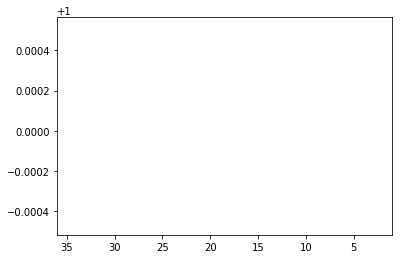

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import animation, rc
from IPython.display import HTML
matplotlib.rcParams['animation.writer'] = 'avconv'

#load in time series data
loadpath = 'tests/data/rawData/0raw8.txt'
load = np.loadtxt(loadpath)
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(len(load)/10)
ax.set_ylim((np.amin(load), np.amax(load)))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
    x = np.arange(len(load))
    y = load[x-i]
    line.set_data(x, y)
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=100, blit=True)
HTML(anim.to_html5_video())

## III. A Rough Statistical Analysis of Project Potential